In [62]:
import matplotlib.pyplot as plt
import networkx as nx
import pandas as pd
import numpy as np
import random
from random import choice
from itertools import zip_longest

from IPython.display import display


In [2]:
### UNCOMMENT FOR PREPROCESSING
# with open("data.csv", "r") as infile, open("processed.csv", "w") as outfile:
#     for line in infile:
#         splited = line.split(',')[3]
#         outfile.write(splited.upper())
#         outfile.write('\n')

In [6]:
G = nx.Graph()
with open("processed.csv", "r") as infile:
    for k, line in enumerate(infile):
        splited = list(map(str.strip, line.split('&')))
        for i in range(len(splited)):
            G.add_node(splited[i])
            for j in range(i+1, len(splited)):
                G.add_edge(splited[i], splited[j])


## A partir del archivo de datos, genere el grafo de colaboraciones entre autores. Cuente el número de nodos y aristas. Haga una representación gráfica del grafo

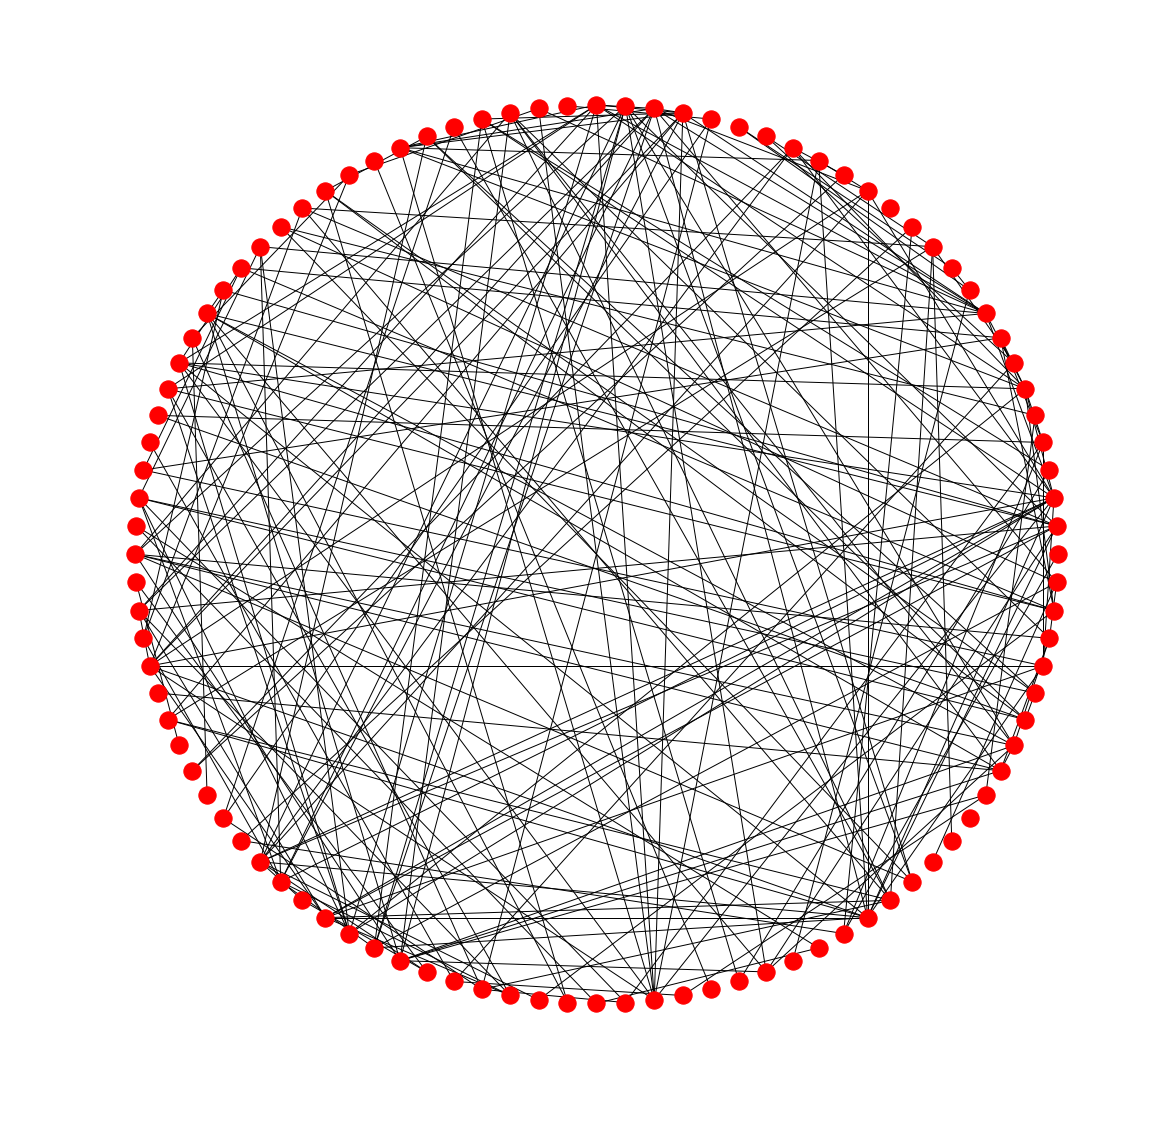

Número de nodos: 3959
Número de aristas: 7920


In [8]:
plt.subplots(figsize=(20,20))
number_of_samples = 100

degree_sequence = sorted([(n[1], n[0]) for n in nx.degree(G)], reverse=True)

# i = 0
# sample = []
# while i < len(degree_sequence) and len(sample) < number_of_samples:
#     if np.random.choice([0,1], p=[0.8, 0.2]) == 1:
#         sample.append(degree_sequence[i][1])
#     i+=1
sample = [n[1] for i, n in enumerate(degree_sequence) if i < number_of_samples]

GAux = nx.subgraph(G, sample)
nx.draw_shell(GAux)

plt.show()

print('Número de nodos:', nx.number_of_nodes(G))
print('Número de aristas:', nx.number_of_edges(G))

## Grafique la distribución del grado de los autores, en escalas lineales, semilogarítmica, y log-log. Argumente, a partir de los gráficos, de qué tipo de distribución se trata

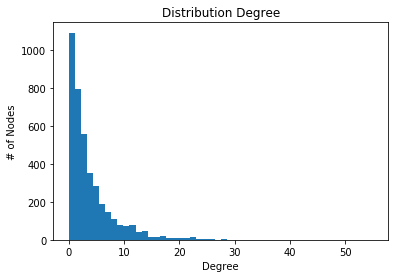

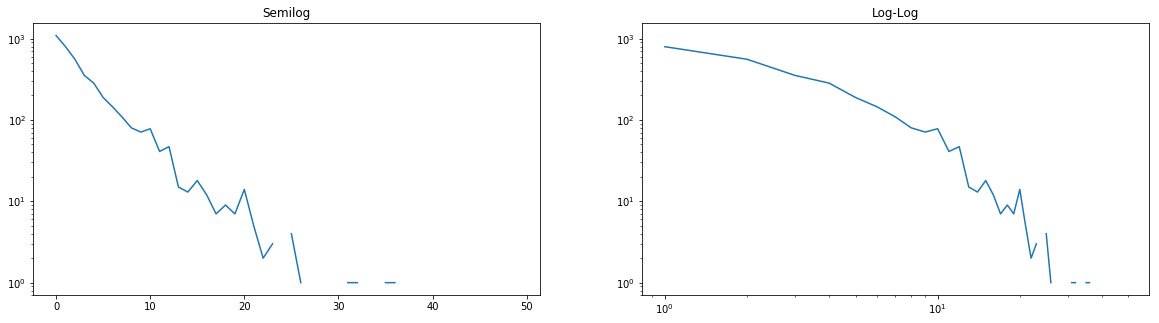

In [60]:
plt.hist([n[0] for n in degree_sequence], bins=50)
plt.title('Distribution Degree')
plt.xlabel('Degree')
plt.ylabel('# of Nodes')
plt.show()

_, axs = plt.subplots(1, 2, figsize = (20, 5))

h , b = np.histogram([n[0] for n in degree_sequence], bins=50)
axs[0].semilogy(h)
axs[0].set_title('Semilog')
axs[1].loglog(h)
axs[1].set_title('Log-Log')
plt.show()


RESPONDER

## Calcule el número de componentes conexas del grafo. Muestre el tamaño de la componente mayor, o componente gigante

In [10]:
connected_components = nx.connected_component_subgraphs(G)

graphs = list(connected_components)
print('Número de componentes conexas:', len(graphs))
max_component = max(graphs, key=len)
print('Tamaño de la componente gigante:', nx.number_of_nodes(max_component))

Número de componentes conexas: 506
Tamaño de la componente gigante: 3041


## Trabajando con la componente gigante del grafo, estudie, parándose en un nodo al azar, cómo aumenta el número de autores alcanzados a medida que se aleja del nodo semilla. Grafique el número de autores alcanzados en función de la distancia al nodo semilla. Grafique también el número de nuevos autores que se agregan en cada paso, y estime el máximo de esta función. Pruebe con varios nodos semillas y analice la robustez de este resultado. Discuta el significado de los gráficos y su relación con el fenómeno de seis grados de separación

In [99]:
acum_new_nodes = []
sum_new_nodes_per_level = []
trials = 200
for _ in range(trials):
    trial_acum_new_nodes = [1]
    new_nodes_per_level = []
    
    random_node = random.choice(list(max_component.nodes()))
    visited = set()
    visited.add(random_node)
    current_level_nodes = set()
    current_level_nodes.add(random_node)
    next_level_nodes = set()

    while current_level_nodes:
        for node in current_level_nodes:
            neighbors = max_component.neighbors(node)
            for neighbor in neighbors:
                if neighbor not in visited:
                    visited.add(neighbor)
                    next_level_nodes.add(neighbor)

        new_nodes_per_level.append(len(next_level_nodes))
        trial_acum_new_nodes.append(trial_acum_new_nodes[-1] + len(next_level_nodes))
        current_level_nodes = next_level_nodes
        next_level_nodes = set()

    sum_new_nodes_per_level = [sum(n) for n in zip_longest(sum_new_nodes_per_level, new_nodes_per_level, fillvalue=0)]
    acum_new_nodes = [sum(n) for n in zip_longest(acum_new_nodes, trial_acum_new_nodes, fillvalue=0)]

mean_new_nodes_per_level = list(map(lambda x: x/trials, sum_new_nodes_per_level))
mean_acum_new_nodes = list(map(lambda x: x/trials, acum_new_nodes))

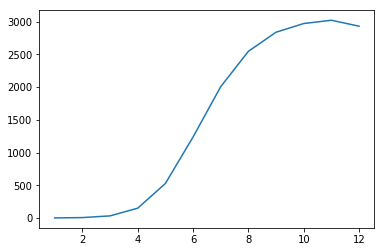

[1.0, 6.06, 32.045, 149.37, 526.16, 1236.0, 2005.23, 2545.98, 2837.695, 2970.505, 3020.875, 2929.955, 2097.54, 1018.66, 395.33, 76.025]


In [101]:
plt.plot(list(range(1,len(mean_acum_new_nodes[:12])+1)), mean_acum_new_nodes[:12])
plt.show()
print(mean_acum_new_nodes)

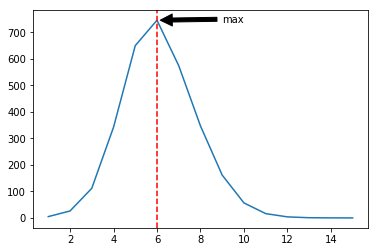

In [94]:
plt.plot(list(range(1,len(mean_new_nodes_per_level)+1)), mean_new_nodes_per_level)

max_y = max(mean_new_nodes_per_level)
max_x = mean_new_nodes_per_level.index(max_y) + 1
plt.annotate('max', xy=(max_x, max_y), xytext=(max_x + 3, max_y * 0.99),
            arrowprops=dict(facecolor='black', shrink=0.05))
plt.axvline(x=max_x, color='red', linestyle='--')

plt.show()

## Compute el coeficiente de clustering C y el camino mínimo medio l para la componente gigante. Genere un grafo aleatorio con la misma distribución de grado y compute las mismas medidas para este grafo. Compare e interprete los resultados. ¿Se trata de un grafo con estructura de mundos pequeños?

In [88]:
clustering = nx.algorithms.cluster.clustering(max_component)
avg_clustering = np.mean([clustering[k] for k in clustering])
avg_shortest_path = nx.algorithms.shortest_paths.generic.average_shortest_path_length(max_component)

print avg_clustering, avg_shortest_path


0.482186054485 6.07115496115
0.439089585193


In [89]:
Gwatts_strogatz = nx.watts_strogatz_graph(nx.number_of_nodes(max_component), 6, 0.1)
watts_strogatz_clustering = nx.algorithms.cluster.clustering(Gwatts_strogatz)
watts_strogatz_avg_clustering = np.mean([clustering[k] for k in clustering])
watts_strogatz_avg_shortest_path = nx.algorithms.shortest_paths.generic.average_shortest_path_length(Gwatts_strogatz)

print watts_strogatz_avg_clustering, watts_strogatz_avg_shortest_path


0.439089585193 7.3815525537


## Discuta cómo haría para individuar a los autores "estrella" del campo. Evalúe quiénes son estos autores según por lo menos dos métricas diferentes. Analice qué sucedería con la comunidad si estos autores desapareciesen. En particular, determine cuántos autores deberían desaparecer para que desaparezca la componente gigante del grafo